# Install Required Libraries

In [ ]:
!pip install astropy matplotlib numpy scikit-image tqdm


# Download FITS Files into Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

save_dir = '/content/drive/MyDrive/CHASE_Data/'


In [ ]:
import os

# Directory to save the data
save_dir = '/content/drive/MyDrive/CHASE_Data/'
os.makedirs(save_dir, exist_ok=True)

# FITS file URLs
urls = [
    "https://ssdc.nju.edu.cn/chase/2025/5/11/RSM20250511T001143_0000_FE.fits?AWSAccessKeyId=AK0ZAC4GDAAD6ODF0MA5&Expires=1751203801&Signature=KGrOpmJ1YK8r4QL2gio9gIGlc0I%3D",
    "https://ssdc.nju.edu.cn/chase/2025/5/11/RSM20250511T001143_0000_HA.fits?AWSAccessKeyId=AK0ZAC4GDAAD6ODF0MA5&Expires=1751203801&Signature=tw%2FyYkEGVT2CaM0Rwdh0x%2B4bfn0%3D",
    "https://ssdc.nju.edu.cn/chase/2025/5/11/RSM20250511T001255_0001_FE.fits?AWSAccessKeyId=AK0ZAC4GDAAD6ODF0MA5&Expires=1751203801&Signature=7YcExZkDjMN0lgJElVa8KHn%2FbCg%3D"
]

# Download using wget
for url in urls:
    print("To install uncomment the line below")
    # !wget -P "$save_dir" "$url"


To install uncomment the line below
To install uncomment the line below
To install uncomment the line below


In [ ]:
import os

# Path to your CHASE data directory
data_dir = '/content/drive/MyDrive/CHASE_Data/'

# Rename messy filenames to clean ones
rename_map = {
    "RSM20250511T001143_0000_FE.fits": "RSM_0000_FE.fits",
    "RSM20250511T001143_0000_HA.fits": "RSM_0000_HA.fits",
    "RSM20250511T001255_0001_FE.fits": "RSM_0001_FE.fits",
}

# Find and rename downloaded files
for messy_name, clean_name in rename_map.items():
    for f in os.listdir(data_dir):
        if messy_name in f:
            old_path = os.path.join(data_dir, f)
            new_path = os.path.join(data_dir, clean_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {f} → {clean_name}")


# **Load and Visualize One FITS File**

Filename: /content/drive/MyDrive/CHASE_Data/RSM_0000_HA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (2304, 2313)   int16   
  1  COMPRESSED_IMAGE    1 CompImageHDU     49   (2304, 2313, 118)   int16   
Data shape: (118, 2313, 2304)


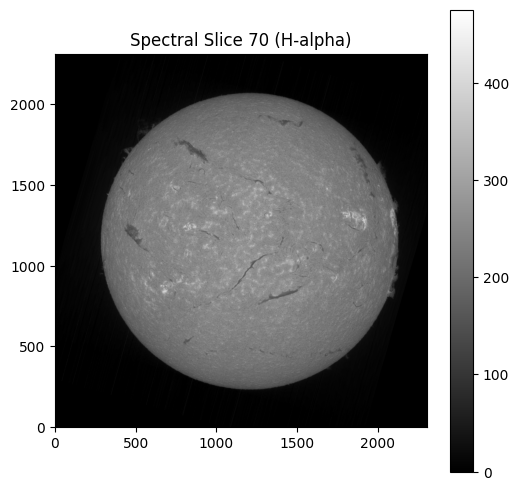

In [ ]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Load cleaned file
ha_file = os.path.join(data_dir, "RSM_0000_HA.fits")
hdul = fits.open(ha_file)
hdul.info()

# Load data from extension 1
data = hdul[1].data
print("Data shape:", data.shape)  # (spectral, x, y)

# Plot one slice (e.g. 70th spectral index)
plt.figure(figsize=(6, 6))
plt.imshow(data[70, :, :], origin="lower", cmap="gray")
plt.title("Spectral Slice 70 (H-alpha)")
plt.colorbar()
plt.show()


# Spatial Calibration

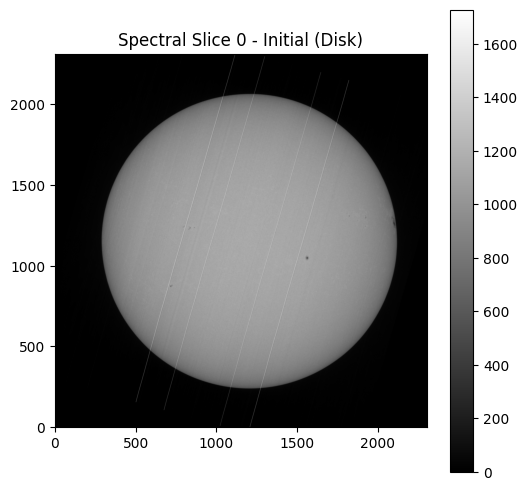

In [ ]:
# Use spectral slice 0 (the wing, closest to continuum)
disk_image = data[0]

plt.figure(figsize=(6, 6))
plt.imshow(disk_image, origin="lower", cmap="gray")
plt.title("Spectral Slice 0 - Initial (Disk)")
plt.colorbar()
plt.show()


In [ ]:
def find_disk_center(image, threshold_ratio=0.2):
    norm_image = image / np.max(image)
    mask = norm_image > threshold_ratio

    # Debug: check how much of the image is considered disk
    print(f"Disk mask covers {np.sum(mask)} pixels")

    y_coords, x_coords = np.nonzero(mask)

    if len(x_coords) == 0 or len(y_coords) == 0:
        raise ValueError("Threshold too high or image too dark to detect disk!")

    center_x = int(np.mean(x_coords))
    center_y = int(np.mean(y_coords))

    print(f"Detected disk center at: x={center_x}, y={center_y}")
    return center_x, center_y, mask

# Run the disk center detection
cx, cy, mask = find_disk_center(disk_image)


Disk mask covers 2611001 pixels
Detected disk center at: x=1200, y=1148


In [ ]:
def recenter_image_cube(data_cube, threshold_ratio=0.2):
    height, width = data_cube.shape[1:3]
    target_center = (width // 2, height // 2)
    print(f"Target center (image midpoint): x={target_center[0]}, y={target_center[1]}")

    # Find current solar center
    cx, cy, _ = find_disk_center(data_cube[0], threshold_ratio)

    dx = target_center[0] - cx
    dy = target_center[1] - cy
    print(f"Shifting image by dx={dx}, dy={dy}")

    shifted_cube = np.zeros_like(data_cube)

    for i in range(data_cube.shape[0]):
        shifted_cube[i] = np.roll(
            np.roll(data_cube[i], dx, axis=1),
            dy, axis=0
        )

    return shifted_cube, (dx, dy)

# Apply recentering
shifted_data, (dx, dy) = recenter_image_cube(data)


Target center (image midpoint): x=1152, y=1156
Disk mask covers 2611001 pixels
Detected disk center at: x=1200, y=1148
Shifting image by dx=-48, dy=8


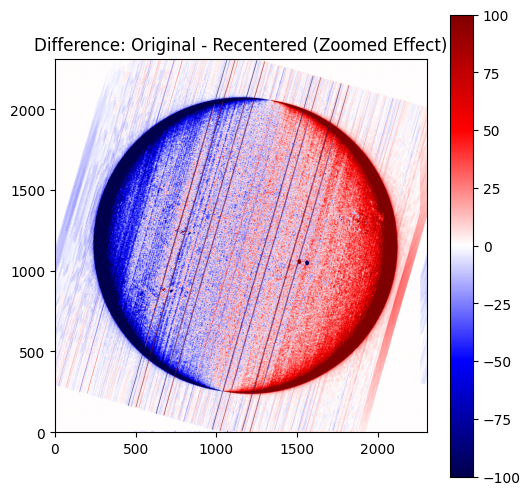

In [ ]:
import matplotlib.pyplot as plt

diff = data[0] - shifted_data[0]

plt.figure(figsize=(6, 6))
plt.imshow(diff, origin='lower', cmap='seismic', vmin=-100, vmax=100)
plt.title('Difference: Original - Recentered (Zoomed Effect)')
plt.colorbar()
plt.show()


In [ ]:
# Pixel to Arcsec Conversion

def pixel_to_arcsec(x_pixel, y_pixel, pixel_scale=0.44):
    """
    Converts pixel coordinates to solar coordinates in arcseconds.
    Assumes center of image is (0,0).
    """
    h, w = data.shape[1:3]
    x_arcsec = (x_pixel - w // 2) * pixel_scale
    y_arcsec = (y_pixel - h // 2) * pixel_scale
    return x_arcsec, y_arcsec

x_arcsec, y_arcsec = pixel_to_arcsec(cx, cy)
print(f"Disk center in arcseconds: x = {x_arcsec:.2f}, y = {y_arcsec:.2f}")


Disk center in arcseconds: x = 21.12, y = -3.52


Sub-pixel shift detected: dy = -8.0000, dx = 48.0000


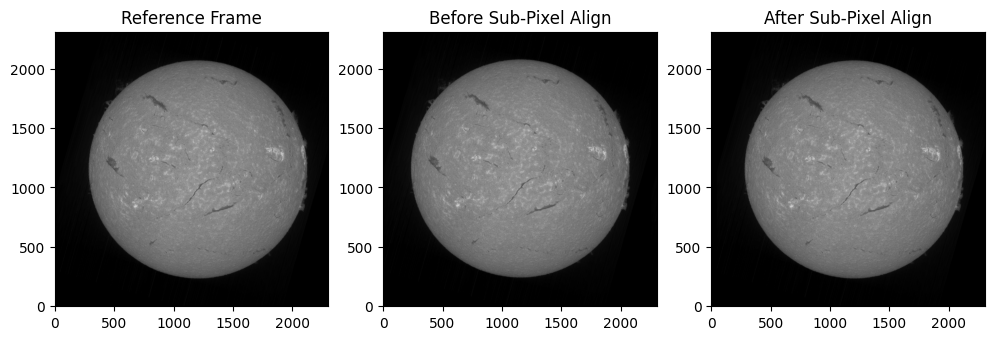

In [ ]:
# Sub-Pixel Alignment (Optional)

!pip install scikit-image

from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

def align_subpixel(reference_image, target_image, upsample_factor=100):
    """
    Aligns target_image to reference_image with sub-pixel precision using phase cross-correlation.
    """
    shift_yx, error, diffphase = phase_cross_correlation(reference_image, target_image, upsample_factor=upsample_factor)
    print(f"Sub-pixel shift detected: dy = {shift_yx[0]:.4f}, dx = {shift_yx[1]:.4f}")
    aligned_image = shift(target_image, shift=shift_yx, order=3)
    return aligned_image, shift_yx

# Example usage
ref_frame = data[70]
target_frame = shifted_data[70]
aligned_frame, subpixel_shift = align_subpixel(ref_frame, target_frame)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(ref_frame, origin='lower', cmap='gray')
plt.title("Reference Frame")

plt.subplot(1, 3, 2)
plt.imshow(target_frame, origin='lower', cmap='gray')
plt.title("Before Sub-Pixel Align")

plt.subplot(1, 3, 3)
plt.imshow(aligned_frame, origin='lower', cmap='gray')
plt.title("After Sub-Pixel Align")
plt.show()


# Spectral Calibration

In [29]:
def extract_qs_region(data_cube, region_size=100):
    # Assume data is already recentered
    h, w = data_cube.shape[1:]
    center_x, center_y = w // 2, h // 2
    half = region_size // 2

    # Bounding box for QS region
    x1, x2 = center_x - half, center_x + half
    y1, y2 = center_y - half, center_y + half

    # Extract sub-cube [spectral, region_size, region_size]
    qs_subcube = data_cube[:, y1:y2, x1:x2]

    print(f"QS Region extracted at: x=[{x1},{x2}], y=[{y1},{y2}]")
    return qs_subcube

qs_subcube = extract_qs_region(shifted_data, region_size=100)


QS Region extracted at: x=[1102,1202], y=[1106,1206]


In [ ]:
# Mean over spatial axes → gives 1D spectrum
qs_profile = np.mean(qs_subcube, axis=(1, 2))

print("Spectral profile shape:", qs_profile.shape)


Spectral profile shape: (118,)


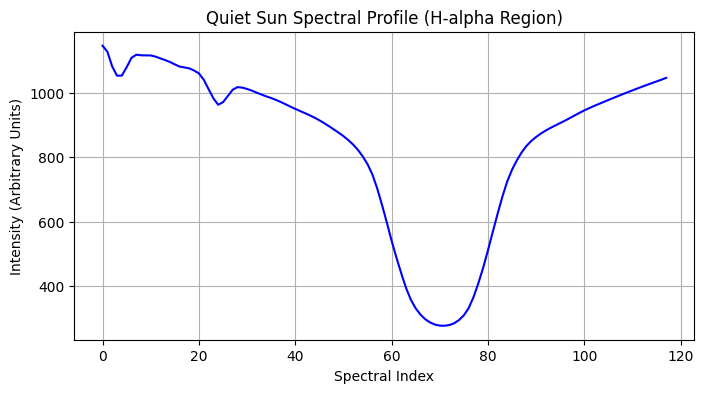

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(qs_profile, color='blue')
plt.title("Quiet Sun Spectral Profile (H-alpha Region)")
plt.xlabel("Spectral Index")
plt.ylabel("Intensity (Arbitrary Units)")
plt.grid(True)
plt.show()


In [ ]:
# Pixel to Arcsec Conversion

def pixel_to_arcsec(x_pixel, y_pixel, pixel_scale=0.44):
    """
    Converts pixel coordinates to solar coordinates in arcseconds.
    Assumes center of image is (0,0).
    """
    h, w = data.shape[1:3]
    x_arcsec = (x_pixel - w // 2) * pixel_scale
    y_arcsec = (y_pixel - h // 2) * pixel_scale
    return x_arcsec, y_arcsec

x_arcsec, y_arcsec = pixel_to_arcsec(cx, cy)
print(f"Disk center in arcseconds: x = {x_arcsec:.2f}, y = {y_arcsec:.2f}")


Disk center in arcseconds: x = 21.12, y = -3.52


Sub-pixel shift detected: dy = -8.0000, dx = 48.0000


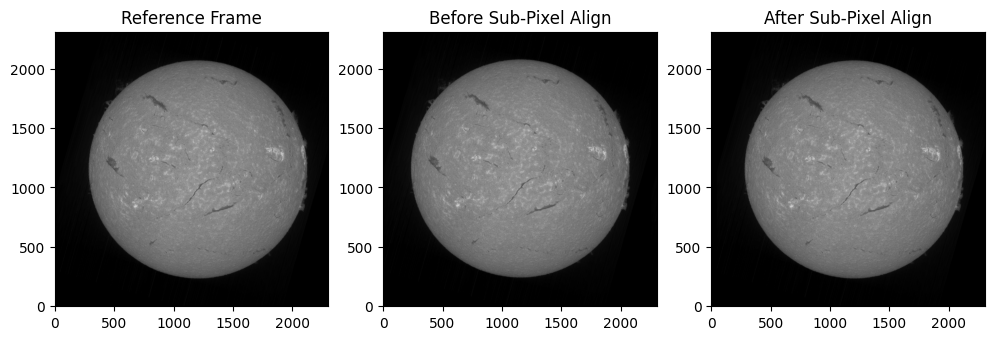

In [ ]:
# Sub-Pixel Alignment (Optional)



from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

def align_subpixel(reference_image, target_image, upsample_factor=100):
    """
    Aligns target_image to reference_image with sub-pixel precision using phase cross-correlation.
    """
    shift_yx, error, diffphase = phase_cross_correlation(reference_image, target_image, upsample_factor=upsample_factor)
    print(f"Sub-pixel shift detected: dy = {shift_yx[0]:.4f}, dx = {shift_yx[1]:.4f}")
    aligned_image = shift(target_image, shift=shift_yx, order=3)
    return aligned_image, shift_yx

# Example usage
ref_frame = data[70]
target_frame = shifted_data[70]
aligned_frame, subpixel_shift = align_subpixel(ref_frame, target_frame)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(ref_frame, origin='lower', cmap='gray')
plt.title("Reference Frame")

plt.subplot(1, 3, 2)
plt.imshow(target_frame, origin='lower', cmap='gray')
plt.title("Before Sub-Pixel Align")

plt.subplot(1, 3, 3)
plt.imshow(aligned_frame, origin='lower', cmap='gray')
plt.title("After Sub-Pixel Align")
plt.show()


# Wavelength Calibration

In [ ]:
# Find index of minimum intensity → H-alpha absorption center
line_center_index = np.argmin(qs_profile)
print(f"H-alpha line center index: {line_center_index}")


H-alpha line center index: 71


In [ ]:
# Constants
h_alpha_ref = 656.28  # nm, H-alpha reference wavelength
dispersion = 0.0025   # nm/pixel (0.025 Å/pixel)

# Build wavelength array
num_points = len(qs_profile)
wavelengths = h_alpha_ref + (np.arange(num_points) - line_center_index) * dispersion


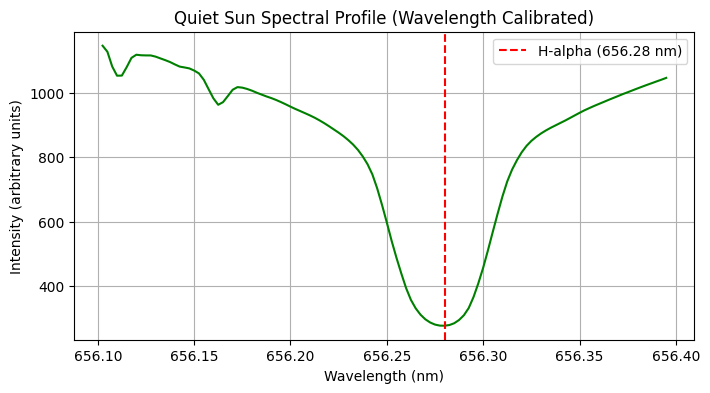

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(wavelengths, qs_profile, color='green')
plt.title("Quiet Sun Spectral Profile (Wavelength Calibrated)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (arbitrary units)")
plt.axvline(656.28, color='red', linestyle='--', label="H-alpha (656.28 nm)")
plt.legend()
plt.grid(True)
plt.show()


# Intensity Calibration

In [ ]:
# Already have this from Step 3
qs_mean_intensity = np.mean(qs_subcube)
print(f"Mean QS Intensity: {qs_mean_intensity:.2f}")


Mean QS Intensity: 846.33


In [ ]:
# Create normalized cube
normalized_cube = shifted_data / qs_mean_intensity

# Optional: clip extreme outliers
normalized_cube = np.clip(normalized_cube, 0, 2)  # or another sensible upper bound


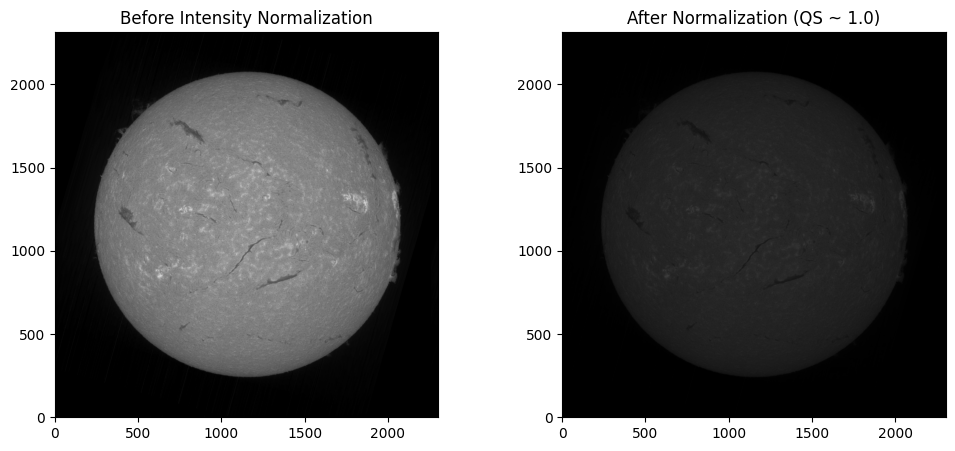

In [ ]:
import matplotlib.pyplot as plt

slice_idx = 70  # any spectral index to inspect

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(shifted_data[slice_idx], origin='lower', cmap='gray')
plt.title("Before Intensity Normalization")

plt.subplot(1, 2, 2)
plt.imshow(normalized_cube[slice_idx], origin='lower', cmap='gray', vmin=0, vmax=2)
plt.title("After Normalization (QS ~ 1.0)")

plt.show()


# Sub-FOV Extraction

In [ ]:
def extract_subregion(cube, center_x, center_y, width, height):
    x1 = max(center_x - width // 2, 0)
    x2 = min(center_x + width // 2, cube.shape[2])
    y1 = max(center_y - height // 2, 0)
    y2 = min(center_y + height // 2, cube.shape[1])

    subcube = cube[:, y1:y2, x1:x2]
    print(f"Extracted region: x=[{x1},{x2}], y=[{y1},{y2}], shape={subcube.shape}")
    return subcube


In [ ]:
center_x, center_y = normalized_cube.shape[2] // 2, normalized_cube.shape[1] // 2
subcube = extract_subregion(normalized_cube, center_x, center_y, 300, 300)


Extracted region: x=[1002,1302], y=[1006,1306], shape=(118, 300, 300)


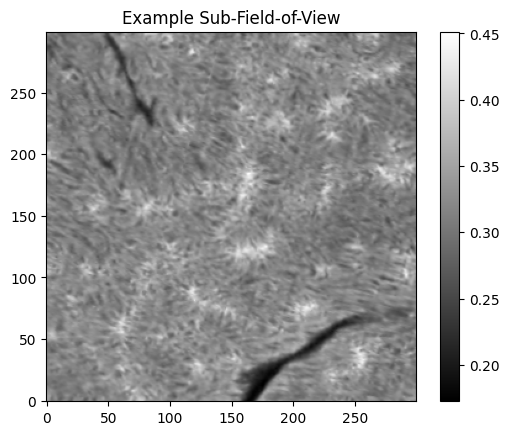

In [ ]:
plt.imshow(subcube[70], origin='lower', cmap='gray')
plt.title("Example Sub-Field-of-View")
plt.colorbar()
plt.show()


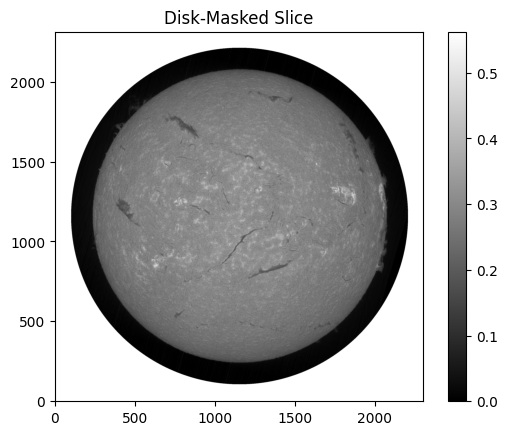

In [ ]:
def create_disk_mask(shape, center_x, center_y, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    dist = (X - center_x)**2 + (Y - center_y)**2
    mask = dist <= radius**2
    return mask

# Example usage
h, w = normalized_cube.shape[1:]
r = min(h, w) // 2 - 100  # leave margin
disk_mask = create_disk_mask((h, w), w // 2, h // 2, r)

# Apply to one slice
masked_slice = np.where(disk_mask, normalized_cube[70], np.nan)

plt.imshow(masked_slice, origin='lower', cmap='gray')
plt.title("Disk-Masked Slice")
plt.colorbar()
plt.show()


# Pipeline Packaging